In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import importlib as il
import glob
import itertools as it
import random
import warnings
import collections

from scipy import optimize


%load_ext ipydex.displaytools
%matplotlib inline

In [2]:
img_dir = "/home/ck/iee-ge/XAI-DIA/image_classification/stage2/single_bars/raw/"
img_path_list = glob.glob(f"{img_dir}/*.jpg")
img_path_list.sort()

img_fpath = img_path_list[0] ##:

img_fpath := '/home/ck/iee-ge/XAI-DIA/image_classification/stage2/single_bars/raw/2023-06-26_06-22-47_C50.jpg'

---

In [3]:
import stage_2a_bar_selection as bs
il.reload(bs)
from stage_2a_bar_selection import (
    load_img,
    rgb,
    get_bbox_list,
    assign_row_col,
    index_combinations,
    find_missing_boxes,
    handle_missing_boxes,
    select_bar_from_file,
    get_raw_cell,
    get_angle,
    correct_angle,
    rotate_img,
)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

CPU times: user 208 ms, sys: 1.51 ms, total: 209 ms
Wall time: 200 ms


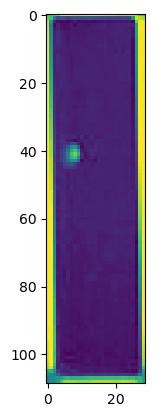

In [4]:
%%time

# extra pixels
ex, ey = 2, 2
img = get_raw_cell(img_fpath, "c", "8", ex, ey, plot=True)

0.83085684300032


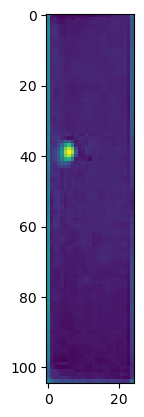

In [5]:
corrected_img, a = correct_angle(img)
print(a)
plt.imshow(corrected_img[ex:-ex, ey:-ey])

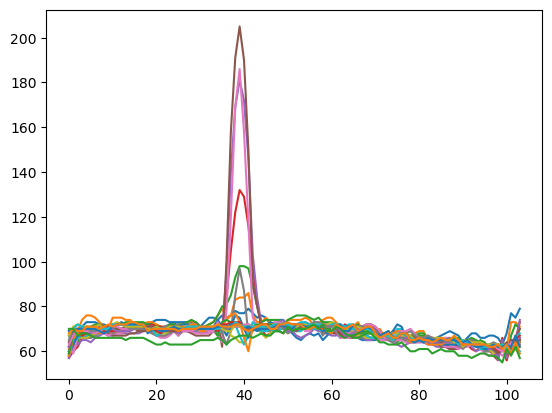

In [6]:
_ = plt.plot(corrected_img[ex:-ex-1, ey+1:-ey-1])

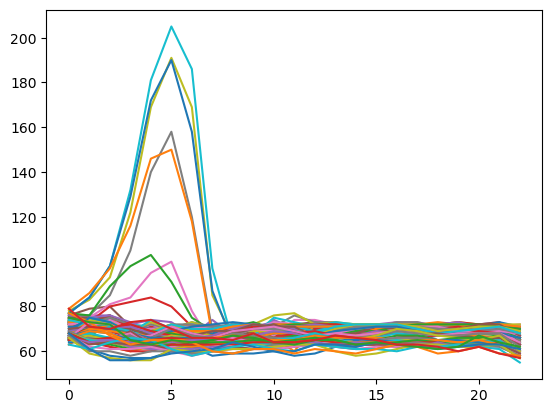

In [7]:
plt.plot(corrected_img[ex:-ex-1, ey+1:-ey-1].T)
pass

In [8]:
np.histogram(corrected_img, bins=[0, 55, 75, 255])

(array([   0, 2316,  845]), array([  0,  55,  75, 255]))

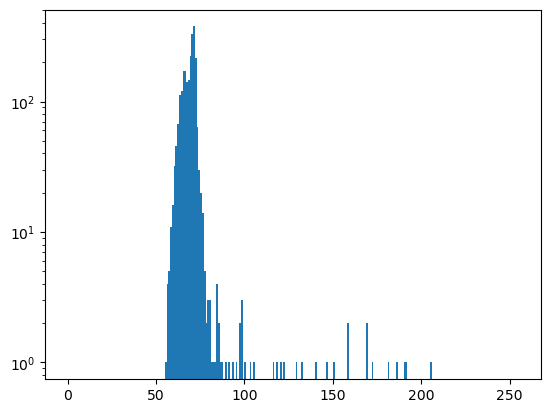

In [9]:
xx = corrected_img[3:-3, 3:-3]*1
hist, bins, bars = plt.hist(xx.flatten(), bins=np.arange(256), log=True)

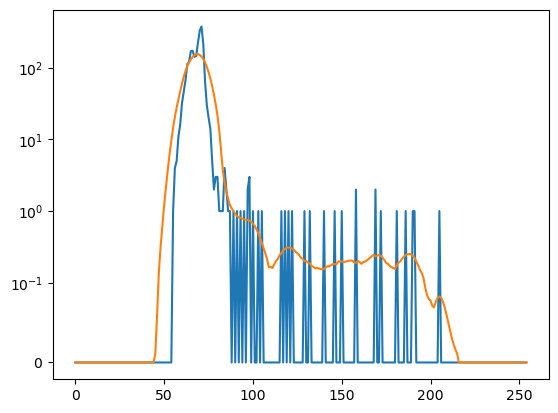

In [12]:
ii = np.arange(255)

def gaussian_kernel(size, sigma):
    x = np.arange(-(size // 2), size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_smooth(data, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = np.convolve(data, kernel, mode='same')
    return smoothed

hist2 = gaussian_smooth(hist, 20, sigma=5)



plt.plot(ii, hist)
plt.plot(ii, hist2)

plt.yscale('symlog', linthresh=0.1)

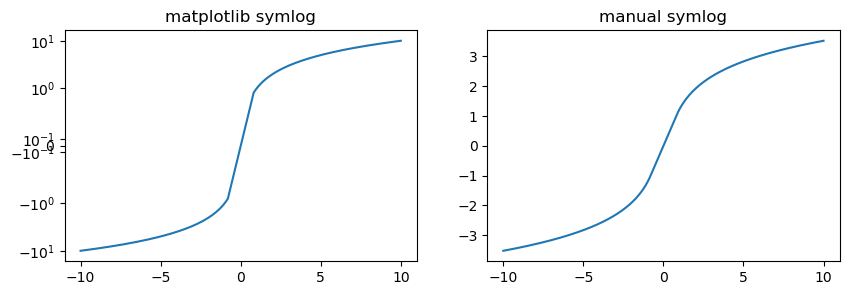

In [14]:
def symlog_transform(x, linthresh):
    eps = 1e-8  # correction for places where x is near 0
    # this prevents warnings, but changes nothing for the value (as long as linthresh > eps)
    
    
    return np.where(
        np.abs(x) > linthresh,
        np.sign(x) * np.log(np.abs(x)/linthresh + eps*(np.abs(x)/linthresh < eps)) + np.sign(x),
        x/linthresh
    )


xx = np.linspace(-10, 10, 1000)
ls = 0.8

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3));

plt.sca(ax1)
plt.plot(xx, xx)
plt.yscale('symlog', linthresh=ls)
plt.title("matplotlib symlog")

plt.sca(ax2)
plt.title("manual symlog")
yy = symlog_transform(xx, linthresh=ls)
plt.plot(xx, yy)


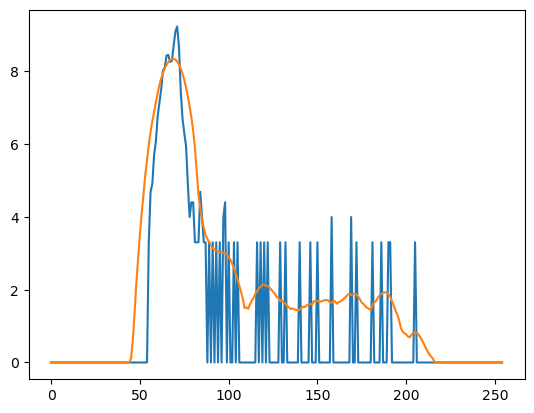

In [15]:
plt.plot(ii, symlog_transform(hist, linthresh=0.1))
plt.plot(ii, symlog_transform(hist2, linthresh=0.1))

# plt.yscale('symlog', linthresh=0.1)

In [16]:
ii = np.arange(255)

def gaussian_kernel(size, sigma):
    x = np.arange(-(size // 2), size // 2 + 1)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_smooth(data, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = np.convolve(data, kernel, mode='same')
    return smoothed

def symlog_transform(x, linthresh):
    eps = 1e-8  # correction for places where x is near 0
    # this prevents warnings, but changes nothing for the value (as long as linthresh > eps)
    
    
    return np.where(
        np.abs(x) > linthresh,
        np.sign(x) * np.log(np.abs(x)/linthresh + eps*(np.abs(x)/linthresh < eps)) + np.sign(x),
        x/linthresh
    )


def get_symlog_hist(img_fpath, hr_row, hr_col, ex1=2, ey1=2, ex2=3, ey2=3):
    """
    
    """
    
    img = get_raw_cell(img_fpath, hr_row, hr_col, ex1, ey1, plot=False)
    corrected_img, angle = correct_angle(img)
    
    # trim border (which was increased before rotation)
    data = corrected_img[ex2:-ex2, ey2:-ey2].flatten()
    
    
    hist = np.histogram(data, bins=np.arange(256))[0]
    hist2 = gaussian_smooth(hist, 20, sigma=5)
    
    sl_hist1 = symlog_transform(hist, linthresh=0.1)
    sl_hist2 = symlog_transform(hist2, linthresh=0.1)
    
    return sl_hist1, sl_hist2
    

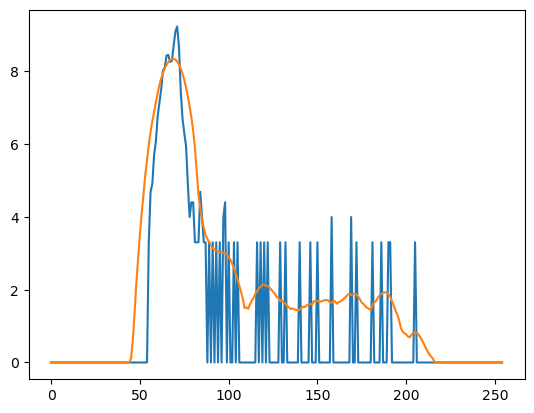

In [17]:
h1, h2 = get_symlog_hist(img_fpath, *"c 8".split())

ii = np.arange(255)
plt.plot(ii, h1)
plt.plot(ii, h2)

In [22]:
# /home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0


img_dir = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0"
img_path_list = glob.glob(f"{img_dir}/*.jpg")
img_path_list.sort()

# omit C100 images

img_path_list2 = []
C100_list = []
for img_fpath in img_path_list:
    # find out if C100 with same base name is in list
    first_parts = img_fpath.split("_")[:-1]
    checkpath = f"{'_'.join(first_parts)}_C100.jpg"
    if checkpath in img_path_list:
        C100_list.append(img_fpath)
    else:
        img_path_list2.append(img_fpath)

img_path_list = img_path_list2

img_fpath = img_path_list[0] ##:

img_fpath := '/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-17-41_C50.jpg'

---

In [39]:
cell_tups = list(it.product("abc", np.array(range(1, 28), dtype=str)))

hist_cache = collections.defaultdict(list)
bad_cells = collections.defaultdict(list)

for img_fpath in img_path_list:
    print(img_fpath)
    for cell_tup in cell_tups:
        print("".join(cell_tup), end="; ")
        try:
            hist_raw, hist_smooth = get_symlog_hist(img_fpath, *cell_tup)
        except RuntimeError:
            bad_cells[img_fpath].append(cell_tup)
        hist_cache[cell_tup].append(hist_smooth)
        
        break
    break
        

/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-17-41_C50.jpg
a1; 

In [37]:
import dill

q = dill.dumps(hist_cache)

In [38]:
len(q)

270545